In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import seaborn as sns

from tqdm import tqdm

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

from matplotlib import cm
from math import log10

from nrclex import NRCLex

In [2]:
# Download stop words
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# Reading Data
df = pd.read_csv('./df_cleaned.csv')

In [4]:
# get stopword
stop_words = set(stopwords.words('english'))
custom_stopwords = {"subject", "original", "message", "sent","thank", "forwarded","said","state","also","would"}
stop_words.update(custom_stopwords)

In [5]:
# Define a function to remove stop words
lemmatizer = WordNetLemmatizer()
def remove_stopwords(text):
    if not isinstance(text, str): 
        return ''  
    words = word_tokenize(text)
    meaningful_words = [lemmatizer.lemmatize(word.lower()) for word in words 
                        if word.lower() not in stop_words and word.isalpha() and len(word) > 3]
    return ' '.join(meaningful_words)

In [6]:
# Adding a progress bar using tqdm
tqdm.pandas()  
df['body_cleaned'] = df['body'].progress_apply(remove_stopwords)

100%|█████████████████████████████████████████████████████████████████████████| 231200/231200 [08:35<00:00, 448.33it/s]


In [7]:
print(df.head())

                          subject                   sender  \
0                  Re: Newsgroups   billc@greenbuilder.com   
1            assoc. for west desk  phillip.allen@enron.com   
2                             Re:  phillip.allen@enron.com   
3  Re: Electric Overage (1824.62)  phillip.allen@enron.com   
4                    Daily Duties  phillip.allen@enron.com   

                   recipients  \
0         strawbale@crest.org   
1   celeste.roberts@enron.com   
2     william.kelly@enron.com   
3  stagecoachmama@hotmail.com   
4        pallen70@hotmail.com   

                                                body  \
0  What other cool newsgroups are available for u...   
1  Celeste, I need two assoc.analyst for the west...   
2  Will, I didn't get to review this. I will give...   
3  Lucy, I will call you this afternoon to discus...   
4   Forwarded by Phillip K AllenHOUECT on 0820200...   

                                        body_cleaned  
0  cool newsgroups available alterna

In [8]:
emails = df.copy()  

In [9]:
# Replace the body column in emails with the contents of the body_cleaned column
emails['body'] = emails['body_cleaned']

In [10]:
# Select only the columns you need
emails = emails[['subject', 'sender', 'recipients', 'body']]

In [11]:
print(emails.body.head(10))

0    cool newsgroups available alternative thinker ...
1    celeste need west trading desk help left voice...
2        review give feedback tomorrow morning phillip
3       lucy call afternoon discus thing email phillip
4    phillip allenhouect lucy gonzalez daily duty p...
5    associate orientation participant within assoc...
6    wade understood number priority deal vehicle s...
7    phillip allenhouect george richards please res...
8    phillip allenhouect team please respond philli...
9                                    ahead level floor
Name: body, dtype: object


In [12]:
#Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

In [13]:
# Defining sentiment analysis functions
def analyze_sentiment(text):
    if isinstance(text, str):  
        sentiment_scores = analyzer.polarity_scores(text)
        return sentiment_scores
    else:
        return None  

In [14]:
#apply sentiment analysis
emails['sentiment'] = emails['body'].progress_apply(analyze_sentiment)

100%|█████████████████████████████████████████████████████████████████████████| 231200/231200 [30:51<00:00, 124.85it/s]


In [15]:
# Split sentiment scores into different columns
emails['positive'] = emails['sentiment'].apply(lambda x: x['pos'])
emails['negative'] = emails['sentiment'].apply(lambda x: x['neg'])
emails['neutral'] = emails['sentiment'].apply(lambda x: x['neu'])
emails['compound'] = emails['sentiment'].apply(lambda x: x['compound'])

In [16]:
print(emails[['body', 'positive', 'negative', 'neutral', 'compound']].head(10))

                                                body  positive  negative  \
0  cool newsgroups available alternative thinker ...     0.159     0.000   
1  celeste need west trading desk help left voice...     0.231     0.000   
2      review give feedback tomorrow morning phillip     0.000     0.000   
3     lucy call afternoon discus thing email phillip     0.000     0.000   
4  phillip allenhouect lucy gonzalez daily duty p...     0.060     0.179   
5  associate orientation participant within assoc...     0.213     0.032   
6  wade understood number priority deal vehicle s...     0.219     0.000   
7  phillip allenhouect george richards please res...     0.224     0.010   
8  phillip allenhouect team please respond philli...     0.380     0.050   
9                                  ahead level floor     0.000     0.000   

   neutral  compound  
0    0.841    0.6486  
1    0.769    0.4019  
2    1.000    0.0000  
3    1.000    0.0000  
4    0.761   -0.6808  
5    0.755    0.8658  
6 

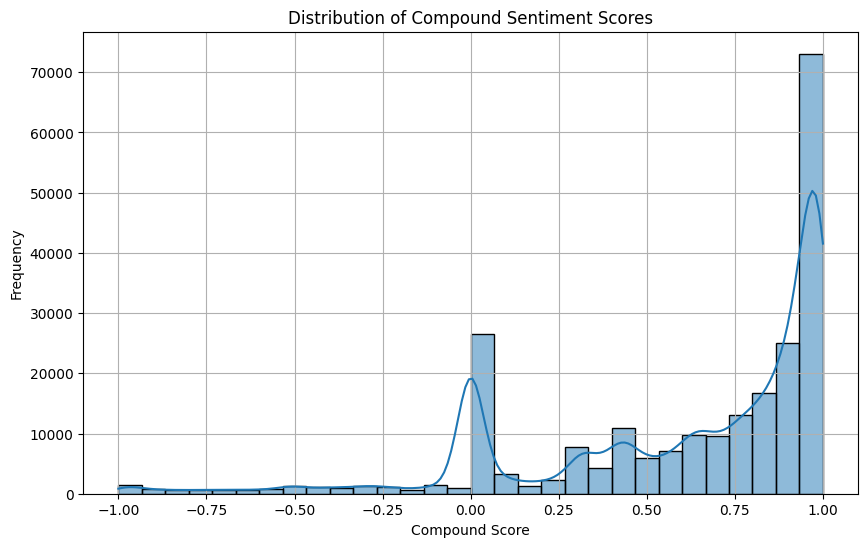

In [17]:
# plot
plt.figure(figsize=(10, 6))
sns.histplot(emails['compound'], bins=30, kde=True)
plt.title('Distribution of Compound Sentiment Scores')
plt.xlabel('Compound Score')
plt.ylabel('Frequency')
plt.grid()
plt.show()

In [18]:
# Filter emails from specific senders
specific_sender = 'jeff.dasovich@enron.com'
jeff_emails = emails[emails['sender'] == specific_sender]

In [19]:
# View filtered results
print(f'Total emails from {specific_sender}: {jeff_emails.shape[0]}')

Total emails from jeff.dasovich@enron.com: 4848


In [20]:
#Applying Sentiment Analysis
jeff_emails['sentiment'] = jeff_emails['body'].apply(analyze_sentiment)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_8032\3148373712.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jeff_emails['sentiment'] = jeff_emails['body'].apply(analyze_sentiment)


In [21]:
# Split sentiment scores into different columns
jeff_emails['positive'] = jeff_emails['sentiment'].apply(lambda x: x['pos'])
jeff_emails['negative'] = jeff_emails['sentiment'].apply(lambda x: x['neg'])
jeff_emails['neutral'] = jeff_emails['sentiment'].apply(lambda x: x['neu'])
jeff_emails['compound'] = jeff_emails['sentiment'].apply(lambda x: x['compound'])

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_8032\605926173.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jeff_emails['positive'] = jeff_emails['sentiment'].apply(lambda x: x['pos'])
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_8032\605926173.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jeff_emails['negative'] = jeff_emails['sentiment'].apply(lambda x: x['neg'])
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_8032\605926173.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

In [22]:
print(jeff_emails[['body', 'positive', 'negative', 'neutral', 'compound']].head())

                                                   body  positive  negative  \
3574  timbob attached letter lynch explaining info t...     0.137     0.000   
3593  jeff dasovichsfoees jeff dasovich paul kaufman...     0.163     0.018   
3604  appears pattern forming administration seems m...     0.046     0.056   
3605  deregulation conspiracy incompetence even ener...     0.128     0.114   
3610  wall street journal california critic seek con...     0.093     0.171   

      neutral  compound  
3574    0.863    0.9231  
3593    0.819    0.9163  
3604    0.898   -0.7184  
3605    0.758    0.9153  
3610    0.737   -0.9932  


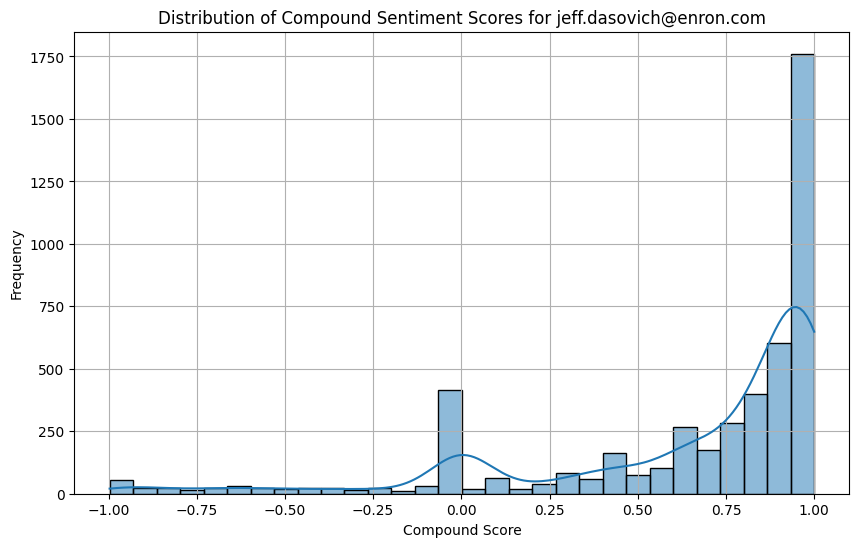

In [23]:
# plot
plt.figure(figsize=(10, 6))
sns.histplot(jeff_emails['compound'], bins=30, kde=True)
plt.title(f'Distribution of Compound Sentiment Scores for {specific_sender}')
plt.xlabel('Compound Score')
plt.ylabel('Frequency')
plt.grid()
plt.show()

In [24]:
# Extract the part where compound is greater than 0
positive_scores = jeff_emails[jeff_emails['compound'] > 0]['compound']

# Extract the part where compound is less than 0
negative_scores = jeff_emails[jeff_emails['compound'] < 0]['compound']

In [25]:
print("Positive Scores Statistics:")
print(positive_scores.describe())
print("\nNegative Scores Statistics:")
print(negative_scores.describe())

Positive Scores Statistics:
count    4108.00000
mean        0.81253
std         0.22026
min         0.02580
25%         0.71800
50%         0.90420
75%         0.97485
max         0.99990
Name: compound, dtype: float64

Negative Scores Statistics:
count    353.000000
mean      -0.535182
std        0.315272
min       -0.996800
25%       -0.831600
50%       -0.557400
75%       -0.250000
max       -0.009500
Name: compound, dtype: float64


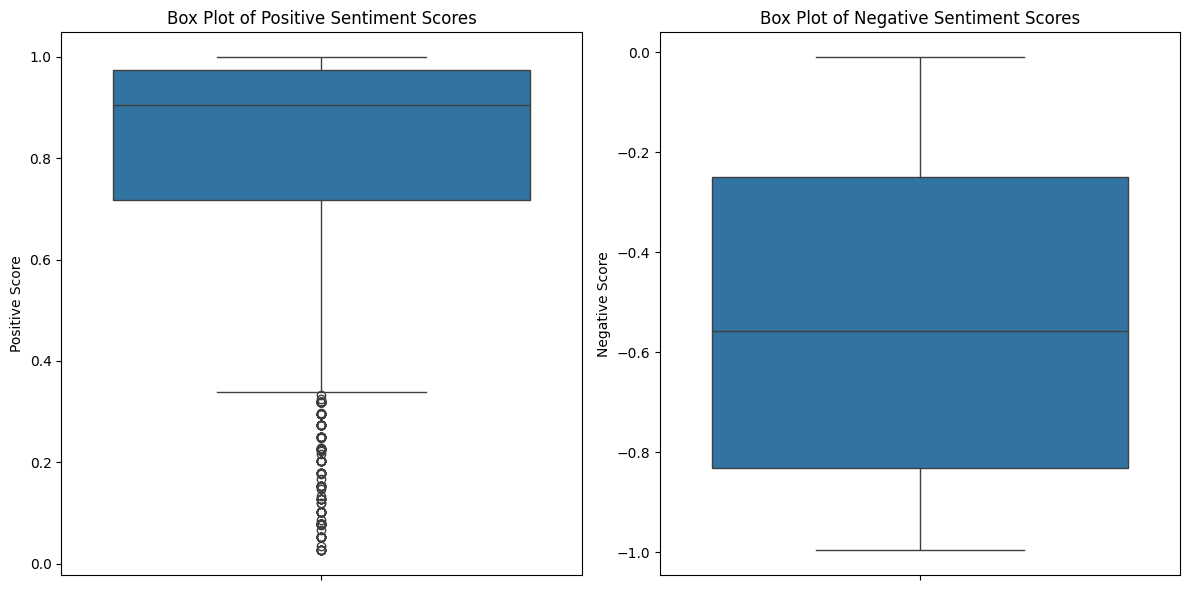

In [26]:
# Draw a box plot
plt.figure(figsize=(12, 6))

# Plotting a box plot of the positive sentiment scores
plt.subplot(1, 2, 1)
sns.boxplot(y=positive_scores)
plt.title('Box Plot of Positive Sentiment Scores')
plt.ylabel('Positive Score')

# Plotting a box plot of negative sentiment scores
plt.subplot(1, 2, 2)
sns.boxplot(y=negative_scores)
plt.title('Box Plot of Negative Sentiment Scores')
plt.ylabel('Negative Score')

plt.tight_layout()
plt.show()

In [27]:
# Filter emotional text
positive_text = " ".join(jeff_emails[jeff_emails['positive'] > jeff_emails['negative']]['body'])
negative_text = " ".join(jeff_emails[jeff_emails['negative'] > jeff_emails['positive']]['body'])

In [28]:
# Generate wordcloud
wordcloud_positive = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(positive_text)
wordcloud_negative = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(negative_text)

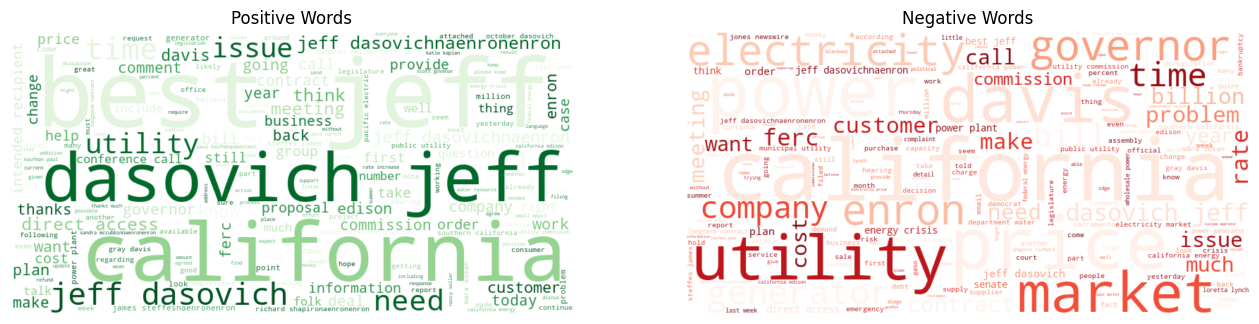

In [29]:
# Draw word cloud
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

# Positive emotions word cloud
axes[0].imshow(wordcloud_positive, interpolation='bilinear')
axes[0].set_title('Positive Words')
axes[0].axis('off')

# Negative emotion word cloud
axes[1].imshow(wordcloud_negative, interpolation='bilinear')
axes[1].set_title('Negative Words')
axes[1].axis('off')

plt.show()

In [30]:
# Filter emails to specific recipients
specific_recipient = 'jeff.dasovich@enron.com'
jeff_recipient_emails = emails[emails['recipients'].str.contains(specific_recipient, na=False, case=False)]

In [31]:
# View filtered results
print(f'Total emails sent to {specific_recipient}: {jeff_recipient_emails.shape[0]}')

Total emails sent to jeff.dasovich@enron.com: 6141


In [32]:
# Defining sentiment analysis functions
def analyze_sentiment(text):
    sentiment_scores = analyzer.polarity_scores(text)
    return sentiment_scores

In [33]:
# Applying Sentiment Analysis
tqdm.pandas()
jeff_recipient_emails['sentiment'] = jeff_recipient_emails['body'].progress_apply(analyze_sentiment)

100%|██████████████████████████████████████████████████████████████████████████████| 6141/6141 [08:07<00:00, 12.59it/s]
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_8032\639912399.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jeff_recipient_emails['sentiment'] = jeff_recipient_emails['body'].progress_apply(analyze_sentiment)


In [34]:
# Split sentiment scores into different columns
jeff_recipient_emails['positive'] = jeff_recipient_emails['sentiment'].apply(lambda x: x['pos'])
jeff_recipient_emails['negative'] = jeff_recipient_emails['sentiment'].apply(lambda x: x['neg'])
jeff_recipient_emails['neutral'] = jeff_recipient_emails['sentiment'].apply(lambda x: x['neu'])
jeff_recipient_emails['compound'] = jeff_recipient_emails['sentiment'].apply(lambda x: x['compound'])

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_8032\2422979914.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jeff_recipient_emails['positive'] = jeff_recipient_emails['sentiment'].apply(lambda x: x['pos'])
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_8032\2422979914.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jeff_recipient_emails['negative'] = jeff_recipient_emails['sentiment'].apply(lambda x: x['neg'])
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_8032\2422979914.py:4: SettingWithCopyWarning: 


In [35]:
print(jeff_recipient_emails[['body', 'positive', 'negative', 'neutral', 'compound']].head())

                                                  body  positive  negative  \
24   please review attached draft enron comment res...     0.330       0.0   
137  merit mentioning initial supply response term ...     0.127       0.0   
200  everyone forgot mention today comment back soo...     0.204       0.0   
429  sarah novoselcorpenron randall rich jeffrey wa...     0.239       0.0   
448  conference call held today ferc staffer discus...     0.153       0.0   

     neutral  compound  
24     0.670    0.8834  
137    0.873    0.8074  
200    0.796    0.9274  
429    0.761    0.5719  
448    0.847    0.9577  


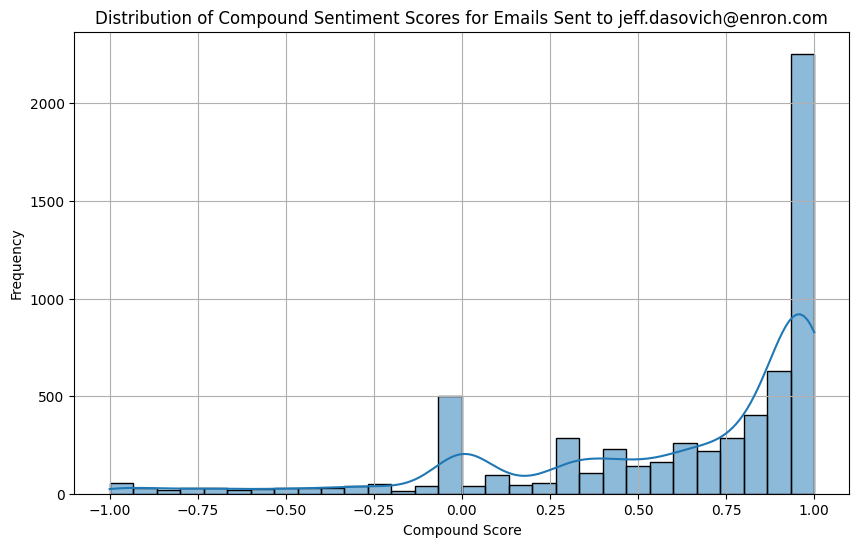

In [36]:
# plot
plt.figure(figsize=(10, 6))
sns.histplot(jeff_recipient_emails['compound'], bins=30, kde=True)
plt.title(f'Distribution of Compound Sentiment Scores for Emails Sent to {specific_recipient}')
plt.xlabel('Compound Score')
plt.ylabel('Frequency')
plt.grid()
plt.show()

In [37]:
# Extract the part where compound is greater than 0
positive_scores = jeff_recipient_emails[jeff_recipient_emails['compound'] > 0]['compound']

# Extract the part where compound is less than 0
negative_scores = jeff_recipient_emails[jeff_recipient_emails['compound'] < 0]['compound']

In [38]:
print("Positive Scores Distribution:")
print(positive_scores.describe())

print("\nNegative Scores Distribution:")
print(negative_scores.describe())

Positive Scores Distribution:
count    5200.000000
mean        0.781247
std         0.253957
min         0.025800
25%         0.636900
50%         0.901200
75%         0.979400
max         1.000000
Name: compound, dtype: float64

Negative Scores Distribution:
count    466.000000
mean      -0.507245
std        0.305230
min       -0.999900
25%       -0.777950
50%       -0.476700
75%       -0.250000
max       -0.025800
Name: compound, dtype: float64


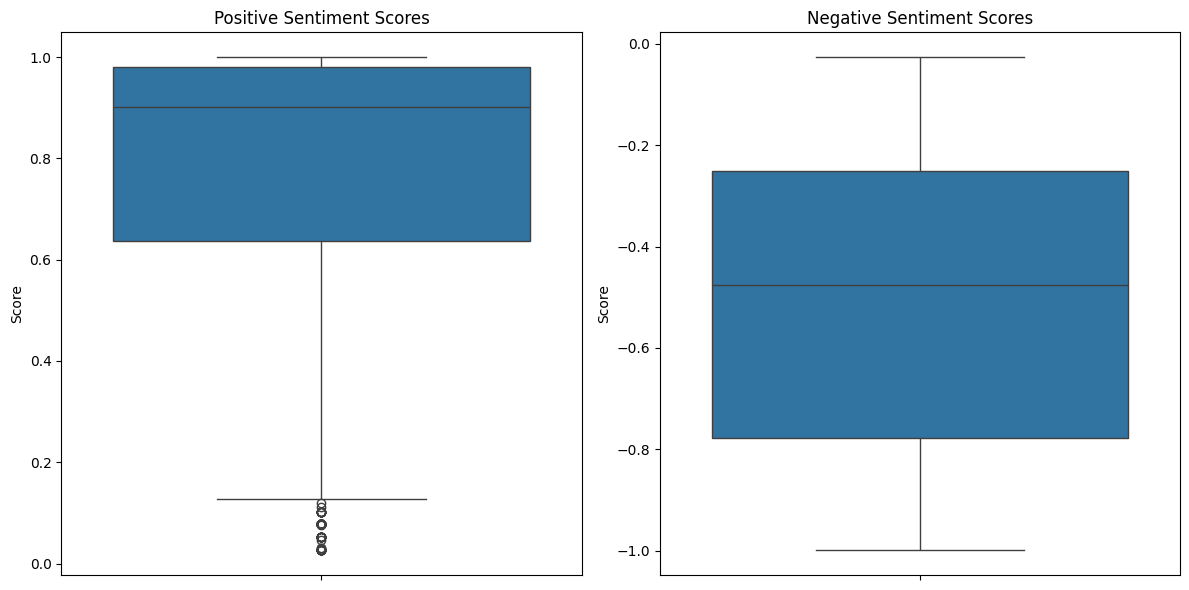

In [39]:
# Draw a box plot
plt.figure(figsize=(12, 6))

# Plotting a box plot of the positive sentiment scores
plt.subplot(1, 2, 1)
sns.boxplot(y=positive_scores)
plt.title('Positive Sentiment Scores')
plt.ylabel('Score')

# Plotting a box plot of negative sentiment scores
plt.subplot(1, 2, 2)
sns.boxplot(y=negative_scores)
plt.title('Negative Sentiment Scores')
plt.ylabel('Score')

plt.tight_layout()
plt.show()

In [40]:
# Filter text for positive and negative sentiment
positive_text = " ".join(jeff_recipient_emails[jeff_recipient_emails['positive'] > jeff_recipient_emails['negative']]['body'])
negative_text = " ".join(jeff_recipient_emails[jeff_recipient_emails['negative'] > jeff_recipient_emails['positive']]['body'])

In [41]:
# Generate wordcloud
wordcloud_positive = WordCloud(width=800, height=400, max_words=50, background_color='white', 
                               stopwords=custom_stopwords, colormap='Greens',contour_color='black', contour_width=1).generate(positive_text)
wordcloud_negative = WordCloud(width=800, height=400, max_words=50, background_color='white', 
                               stopwords=custom_stopwords, colormap='Reds', contour_color='black', contour_width=1).generate(negative_text)

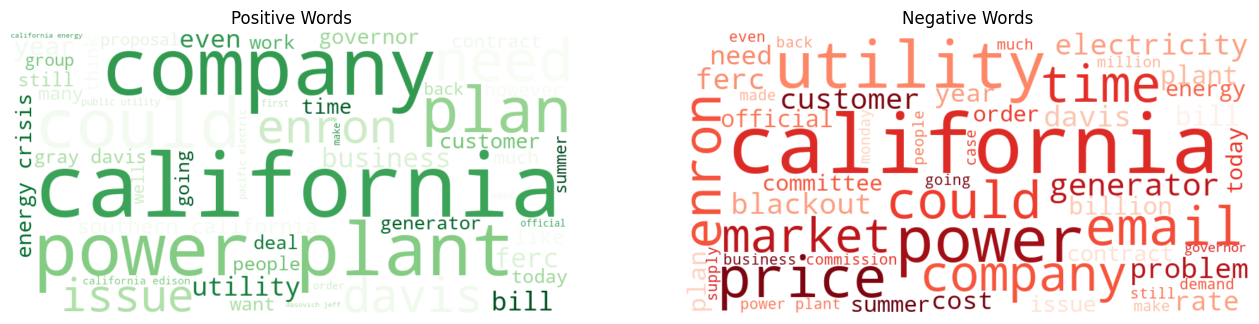

In [42]:
# Draw wordcloud
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Positive emotions wordcloud
axes[0].imshow(wordcloud_positive, interpolation='bilinear')
axes[0].set_title('Positive Words')
axes[0].axis('off')

# negative emotions wordcloud
axes[1].imshow(wordcloud_negative, interpolation='bilinear')
axes[1].set_title('Negative Words')
axes[1].axis('off')

plt.show()

In [43]:
def emotion(x):
    if not isinstance(x, str):  # Check if x is a string
        x = ""  # if not set as None
    text = NRCLex(x)
    if text.top_emotions[0][1] == 0.0:
        return "No emotion"
    return text.top_emotions[0][0]

# Apply sentiment analysis and display a progress bar
emails['Emotion'] = emails['body'].progress_apply(emotion)

100%|████████████████████████████████████████████████████████████████████████| 231200/231200 [03:03<00:00, 1258.35it/s]


In [44]:
emails[['subject', 'sender', 'recipients', 'body', 'Emotion']].head(10)

,subject,sender,recipients,body,Emotion
0,Re: Newsgroups,billc@greenbuilder.com,strawbale@crest.org,cool newsgroups available alternative thinker ...,positive
1,assoc. for west desk,phillip.allen@enron.com,celeste.roberts@enron.com,celeste need west trading desk help left voice...,anticipation
2,Re:,phillip.allen@enron.com,william.kelly@enron.com,review give feedback tomorrow morning phillip,anticipation
3,Re: Electric Overage (1824.62),phillip.allen@enron.com,stagecoachmama@hotmail.com,lucy call afternoon discus thing email phillip,No emotion
4,Daily Duties,phillip.allen@enron.com,pallen70@hotmail.com,phillip allenhouect lucy gonzalez daily duty p...,positive
5,New Associate Orientation - February 12 - Febr...,tracy.arthur@enron.com,"steve.jacobellis@enron.com, mauricio.mora@enro...",associate orientation participant within assoc...,trust
6,For Wade,phillip.allen@enron.com,stagecoachmama@hotmail.com,wade understood number priority deal vehicle s...,trust
7,Westgate,phillip.allen@enron.com,pallen70@hotmail.com,phillip allenhouect george richards please res...,positive
8,Stick it in your Shockmachine!,phillip.allen@enron.com,pallen70@hotmail.com,phillip allenhouect team please respond philli...,positive
9,re: apt. #2,phillip.allen@enron.com,maryrichards7@hotmail.com,ahead level floor,positive


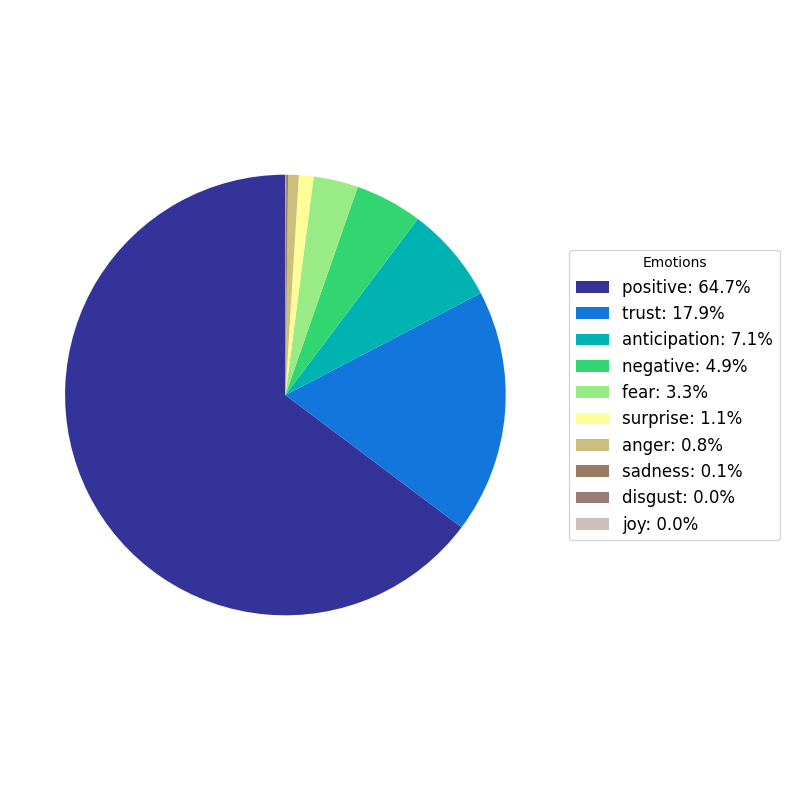

In [45]:
emails_chart = emails[emails.Emotion != "No emotion"]
labels = emails_chart.Emotion.value_counts().index.tolist()
data = emails_chart.Emotion.value_counts()
#number of data points
n = len(data)
#find max value for full ring
k = 10 ** int(log10(max(data)))
m = k * (1 + max(data) // k)

#radius of donut chart
r = 1.5
#calculate width of each ring
w = r / n 

#create colors along a chosen colormap
colors = [cm.terrain(i / n) for i in range(n)]

#create figure, axis
fig, ax = plt.subplots(figsize=(8, 8)) 
ax.axis("equal")  
wedges, texts = ax.pie(data, labels=None, startangle=90, colors=colors)


legend_labels = [f'{label}: {pct:.1f}%' for label, pct in zip(labels, 100 * data / sum(data))]
plt.legend(wedges, legend_labels, title="Emotions", loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)

plt.tight_layout()
plt.show()